<a href="https://colab.research.google.com/github/JorgeRR89/Aprendizaje-automatico---Film-Junky-Union/blob/main/Aprendizaje_automatico_Film_Junky_Union.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descripcipción del proyecto

## 🎬 Introducción

En la actualidad, las plataformas digitales que agrupan opiniones de usuarios enfrentan el reto de **analizar y clasificar grandes volúmenes de texto de manera eficiente y confiable**. En el caso de las reseñas de películas, estas opiniones contienen información valiosa sobre la percepción del público, pero su análisis manual resulta costoso y poco escalable.

En este proyecto, desarrollado para **Film Junky Union**, se aborda el problema de la **detección automática del sentimiento en reseñas de películas**, con el objetivo específico de identificar críticas negativas y positivas de forma precisa. Para lograrlo, se utiliza un conjunto de datos de reseñas de IMDB previamente etiquetadas, aplicando técnicas de **procesamiento de lenguaje natural (NLP)** y **aprendizaje automático**.

A lo largo del proyecto se realiza un análisis exploratorio de los datos, seguido de un proceso de limpieza, normalización y transformación del texto. Posteriormente, se entrenan y evalúan distintos modelos de clasificación basados en representaciones TF-IDF y algoritmos como **Regresión Logística** y **Gradient Boosting**, comparando su desempeño mediante métricas clave como **Accuracy, F1-score, ROC AUC y Average Precision**.

El objetivo final es construir un modelo robusto, interpretable y eficiente que pueda integrarse en los sistemas de Film Junky Union para **automatizar la clasificación de reseñas**, mejorar la experiencia de los usuarios y apoyar la toma de decisiones basada en datos.


## Inicialización

In [ ]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm







In [ ]:
# magics: deben ir en su propia línea
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# %config InlineBackend.figure_format = 'retina'  # para pantallas HiDPI

# estilo (compatible con seaborn reciente)
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

In [ ]:

# para usar progress_apply en pandas
tqdm.pandas()

## Cargar datos

In [ ]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

# sanity check
print(df_reviews.shape)
df_reviews.head(3)

(47331, 17)


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

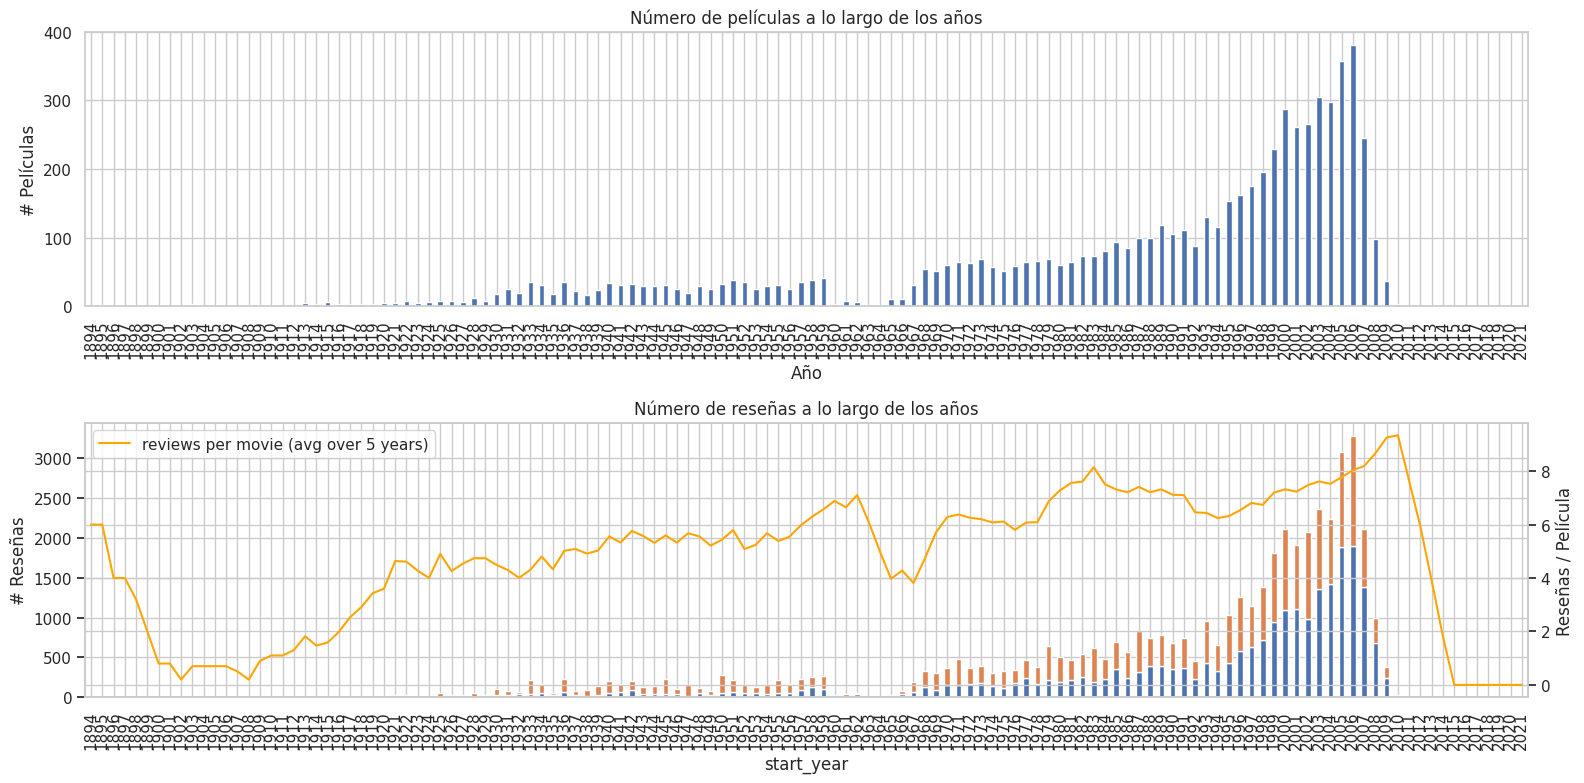

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = (
    df_reviews[['tconst', 'start_year']]
    .drop_duplicates()['start_year']
    .value_counts()
    .sort_index()
)

# asegurar rango continuo de años hasta 2021
years_min = int(dft1.index.min())
years_max = max(int(dft1.index.max()), 2021)
dft1 = dft1.reindex(index=np.arange(years_min, years_max + 1)).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')
ax.set_xlabel('Año')
ax.set_ylabel('# Películas')

ax = axs[1]

dft2 = (
    df_reviews.groupby(['start_year', 'pos'])['pos']
    .count()
    .unstack()
)
years_min2 = int(dft2.index.min())
years_max2 = max(int(dft2.index.max()), 2021)
dft2 = dft2.reindex(index=np.arange(years_min2, years_max2 + 1)).fillna(0)

dft2.plot(kind='bar', stacked=True, ax=ax, label=['neg','pos'])
ax.set_ylabel('# Reseñas')

# reviews per movie
dft2_tot = (
    df_reviews['start_year'].value_counts().sort_index()
    .reindex(index=np.arange(years_min, years_max + 1)).fillna(0)
)
dft3 = (dft2_tot / dft1).replace([np.inf, -np.inf], 0).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5, min_periods=1).mean().plot(
    color='orange', label='reviews per movie (avg over 5 years)', ax=axt
)
axt.set_ylabel('Reseñas / Película')
lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()


Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

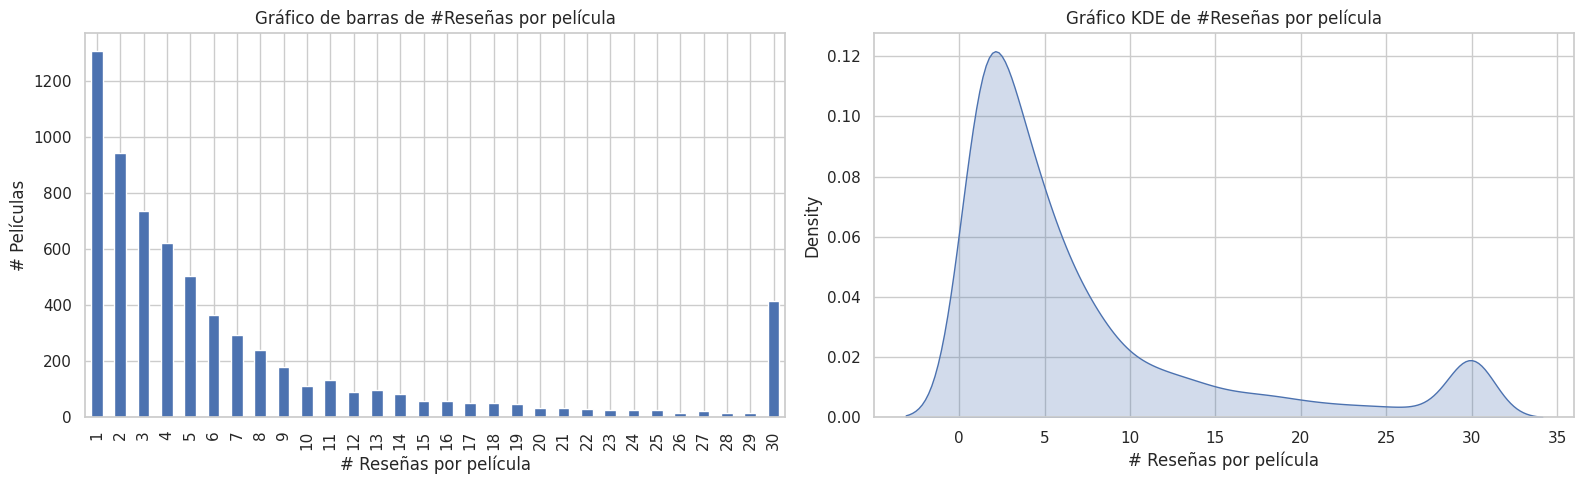

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = (
    df_reviews.groupby('tconst')['review'].count()
    .value_counts()
    .sort_index()
)
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')
ax.set_xlabel('# Reseñas por película')
ax.set_ylabel('# Películas')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax, fill=True)
ax.set_title('Gráfico KDE de #Reseñas por película')
ax.set_xlabel('# Reseñas por película')

fig.tight_layout()


In [ ]:
df_reviews['pos'].value_counts()


0    23715
1    23616
Name: pos, dtype: int64

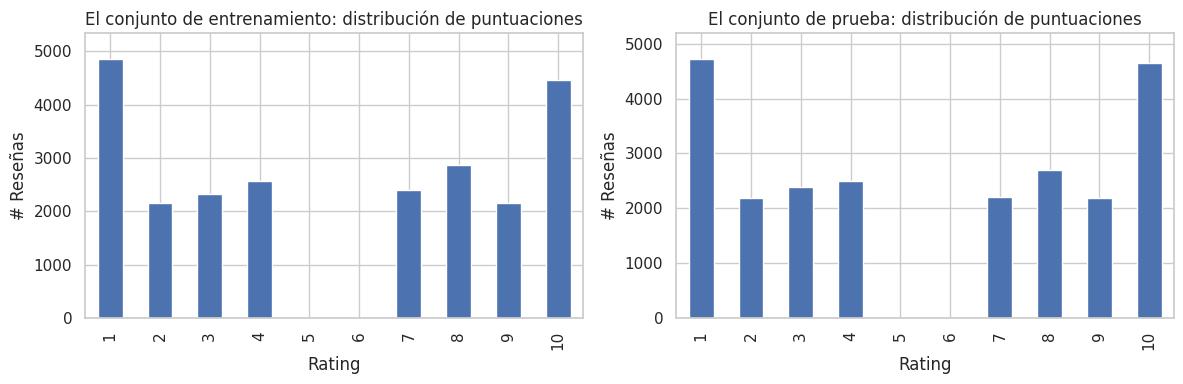

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 10) + 1)).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, max(5000, dft.max() * 1.1)])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')
ax.set_xlabel('Rating')
ax.set_ylabel('# Reseñas')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 10) + 1)).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, max(5000, dft.max() * 1.1)])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')
ax.set_xlabel('Rating')
ax.set_ylabel('# Reseñas')

fig.tight_layout()



Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

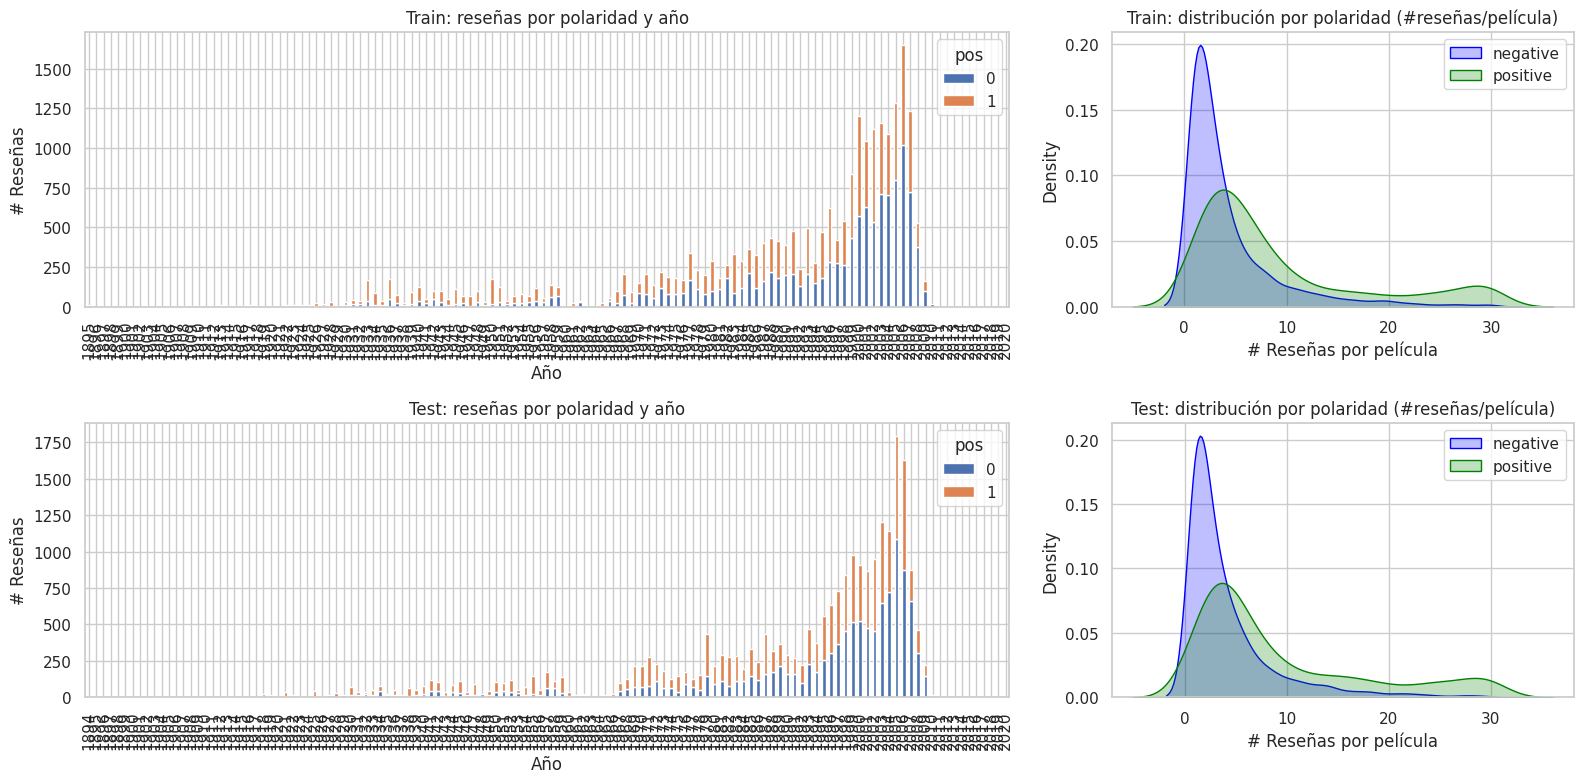

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# Train por año (stacked)
ax = axs[0][0]
dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020) + 1)).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Train: reseñas por polaridad y año')
ax.set_xlabel('Año')
ax.set_ylabel('# Reseñas')

# Train por película (KDE)
ax = axs[0][1]
dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
# Evita warnings si alguna columna falta:
for val, color, lab in [(0, 'blue', 'negative'), (1, 'green', 'positive')]:
    if val in dft.columns:
        sns.kdeplot(dft[val].dropna(), color=color, label=lab, ax=ax, fill=True)
ax.legend()
ax.set_title('Train: distribución por polaridad (#reseñas/película)')
ax.set_xlabel('# Reseñas por película')

# Test por año (stacked)
ax = axs[1][0]
dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020) + 1)).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test: reseñas por polaridad y año')
ax.set_xlabel('Año')
ax.set_ylabel('# Reseñas')

# Test por película (KDE)
ax = axs[1][1]
dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
for val, color, lab in [(0, 'blue', 'negative'), (1, 'green', 'positive')]:
    if val in dft.columns:
        sns.kdeplot(dft[val].dropna(), color=color, label=lab, ax=ax, fill=True)
ax.legend()
ax.set_title('Test: distribución por polaridad (#reseñas/película)')
ax.set_xlabel('# Reseñas por película')

fig.tight_layout()


## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [ ]:
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _get_scores(model, features):
    """
    Devuelve puntajes continuos para curvas ROC/PR y umbralización:
    - Si el modelo tiene predict_proba -> usa la columna de la clase positiva.
    - Si no, pero tiene decision_function -> usa decision_function y lo escala 0..1 para F1 vs threshold.
    """
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(features)[:, 1]
        scores_for_curves = proba
        scores_for_thresholds = proba
    elif hasattr(model, "decision_function"):
        dec = model.decision_function(features)
        scores_for_curves = dec  # ROC/PR aceptan scores no probabilísticos
        # Escalamos a [0,1] para barrer umbrales en F1
        scaler = MinMaxScaler()
        scores_for_thresholds = scaler.fit_transform(dec.reshape(-1,1)).ravel()
    else:
        # Fallback: usa predicción binaria como score (menos informativo)
        pred = model.predict(features)
        scores_for_curves = pred.astype(float)
        scores_for_thresholds = pred.astype(float)
    return scores_for_curves, scores_for_thresholds

def evaluate_model(model, train_features, train_target, test_features, test_target):
    eval_stats = {}
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for split_name, features, target in (
        ('train', train_features, train_target),
        ('test',  test_features,  test_target)
    ):
        eval_stats[split_name] = {}

        # Predicciones duras
        pred_target = model.predict(features)

        # Puntajes continuos (proba o decision_function escalada)
        scores_for_curves, scores_for_thresholds = _get_scores(model, features)

        # F1 vs umbral (barrer 0..1)
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, scores_for_thresholds >= thr) for thr in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, scores_for_curves)
        roc_auc = metrics.roc_auc_score(target, scores_for_curves)
        eval_stats[split_name]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, scores_for_curves)
        aps = metrics.average_precision_score(target, scores_for_curves)
        eval_stats[split_name]['APS'] = aps

        color = 'blue' if split_name == 'train' else 'green'

        # --- Panel 1: F1 vs threshold ---
        ax = axs[0]
        max_idx = int(np.argmax(f1_scores))
        ax.plot(f1_thresholds, f1_scores, color=color,
                label=f'{split_name}, max={f1_scores[max_idx]:.2f} @ {f1_thresholds[max_idx]:.2f}')
        # marcas en umbrales típicos
        for thr in (0.2, 0.4, 0.5, 0.6, 0.8):
            cidx = int(np.argmin(np.abs(f1_thresholds - thr)))
            mcol = 'red' if thr == 0.5 else 'orange'
            ax.plot(f1_thresholds[cidx], f1_scores[cidx], color=mcol, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02]); ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold'); ax.set_ylabel('F1')
        ax.legend(loc='lower center'); ax.set_title('Valor F1')

        # --- Panel 2: ROC ---
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{split_name}, ROC AUC={roc_auc:.2f}')
        # marcas en umbrales aproximados (mapear a índices de roc_thresholds)
        for thr in (0.2, 0.4, 0.5, 0.6, 0.8):
            # roc_thresholds puede contener +/-inf; filtramos válidos
            valid = np.isfinite(roc_thresholds)
            if np.any(valid):
                ridx = int(np.argmin(np.abs(roc_thresholds[valid] - thr)))
                # mapear de vuelta al índice global
                global_indices = np.where(valid)[0]
                gi = global_indices[ridx]
                mcol = 'red' if thr == 0.5 else 'orange'
                ax.plot(fpr[gi], tpr[gi], color=mcol, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02]); ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR'); ax.set_ylabel('TPR')
        ax.legend(loc='lower center'); ax.set_title('Curva ROC')

        # --- Panel 3: PRC ---
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{split_name}, AP={aps:.2f}')
        # pr_thresholds tiene longitud len(precision)-1; ajustamos índices con cuidado
        if pr_thresholds is not None and len(pr_thresholds) > 0:
            for thr in (0.2, 0.4, 0.5, 0.6, 0.8):
                pidx = int(np.argmin(np.abs(pr_thresholds - thr)))
                # índice en precision/recall es pidx+1
                mcol = 'red' if thr == 0.5 else 'orange'
                idx_plot = min(pidx + 1, len(recall) - 1)
                ax.plot(recall[idx_plot], precision[idx_plot], color=mcol, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02]); ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall'); ax.set_ylabel('precision')
        ax.legend(loc='lower center'); ax.set_title('PRC')

        # Métricas duras
        eval_stats[split_name]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[split_name]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats).round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    print(df_eval_stats)

    return df_eval_stats


## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [ ]:
# Normalización básica de texto: minúsculas, solo letras y espacios
df_reviews['review_norm'] = (
    df_reviews['review']
    .astype(str)
    .str.lower()                                     # convertir a minúsculas
    .str.replace(r"[^a-z\s']", '', regex=True)       # mantener solo letras, espacios y apóstrofos
    .str.replace(r"\s+", ' ', regex=True)            # colapsar múltiples espacios
    .str.strip()                                     # eliminar espacios iniciales/finales
)


## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [ ]:
# === División entrenamiento / prueba ===

# Separar los conjuntos según la columna 'ds_part'
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test  = df_reviews.query('ds_part == "test"').copy()

# Variables objetivo (0 = negativo, 1 = positivo)
train_target = df_reviews_train['pos']
test_target  = df_reviews_test['pos']

# Mostrar tamaños para verificar
print("Tamaño del conjunto de entrenamiento:", df_reviews_train.shape)
print("Tamaño del conjunto de prueba:", df_reviews_test.shape)


Tamaño del conjunto de entrenamiento: (23796, 18)
Tamaño del conjunto de prueba: (23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


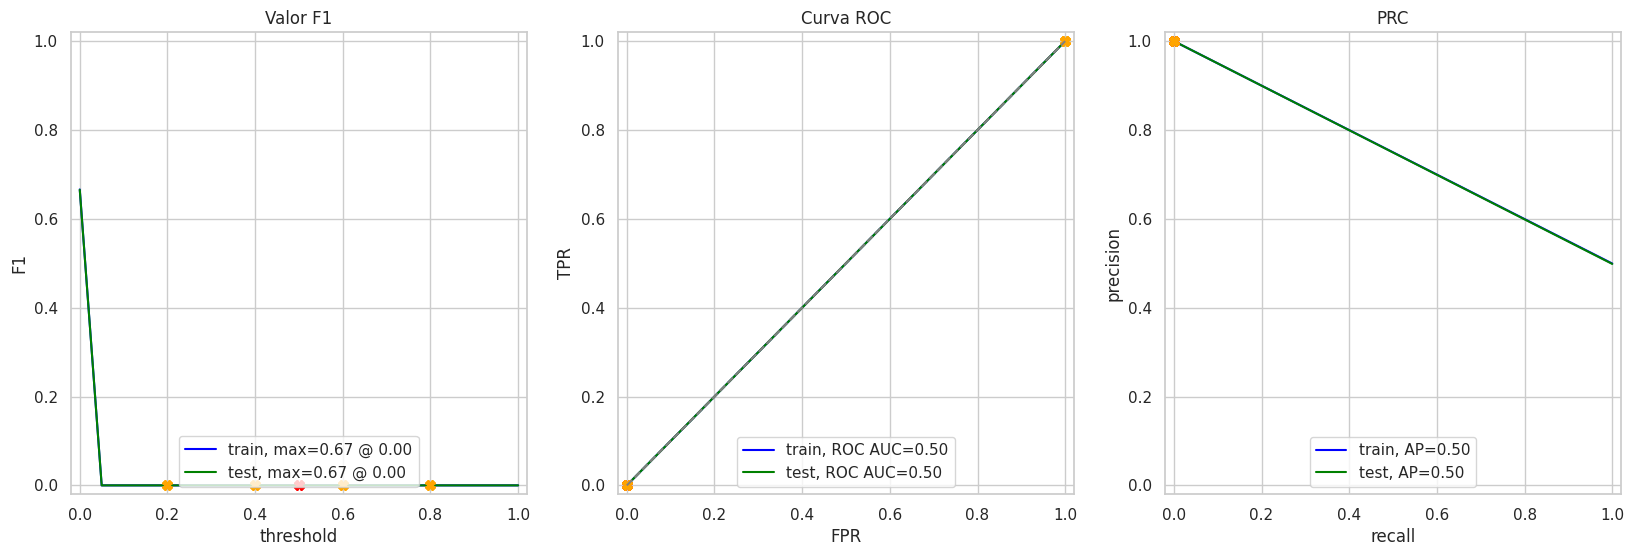

In [ ]:
# === Modelo 0 - Constante (Baseline) ===

from sklearn.dummy import DummyClassifier
import numpy as np

# Placeholders con el número correcto de muestras
train_features_dummy = np.zeros((len(train_target), 1))
test_features_dummy  = np.zeros((len(test_target), 1))

model_0 = DummyClassifier(strategy='most_frequent', random_state=42)
model_0.fit(train_features_dummy, train_target)

_ = evaluate_model(model_0,
                   train_features_dummy, train_target,
                   test_features_dummy,  test_target)



### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

          train  test
Accuracy   0.95  0.88
F1         0.95  0.88
APS        0.99  0.95
ROC AUC    0.99  0.95


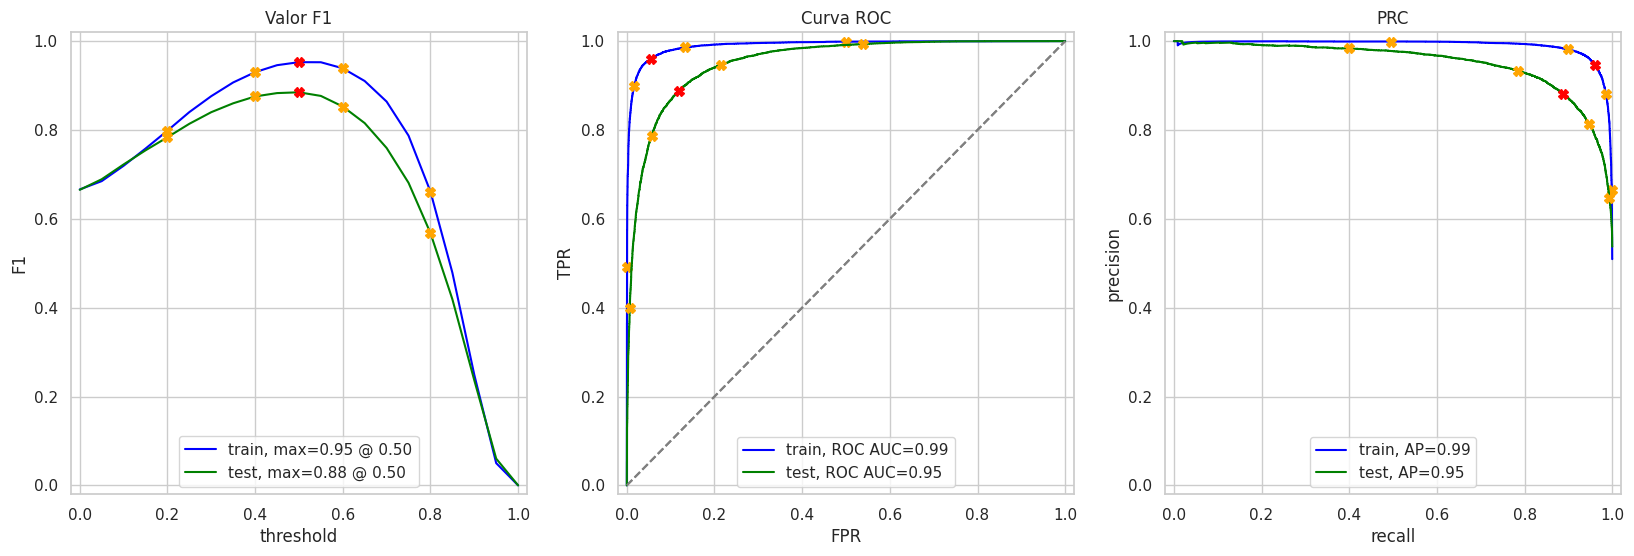

In [ ]:
# === Modelo 1 — NLTK stopwords + TF-IDF + Logistic Regression ===
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords

# Asegurar que las stopwords estén disponibles
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

# Vectorizador TF-IDF
tfidf_1 = TfidfVectorizer(
    stop_words=stop_words,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

# Ajustar en entrenamiento y transformar ambos conjuntos
train_features_1 = tfidf_1.fit_transform(df_reviews_train['review_norm'].astype(str))
test_features_1  = tfidf_1.transform(df_reviews_test['review_norm'].astype(str))

# Modelo: Regresión Logística
model_1 = LogisticRegression(max_iter=2000, solver='liblinear', random_state=42)

# --- ENTRENAR el modelo ---
model_1.fit(train_features_1, train_target)

# --- EVALUAR el modelo ---
_ = evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)



### Modelo 3 - spaCy, TF-IDF y LR

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

          train  test
Accuracy   0.95  0.89
F1         0.95  0.89
APS        0.99  0.95
ROC AUC    0.99  0.96


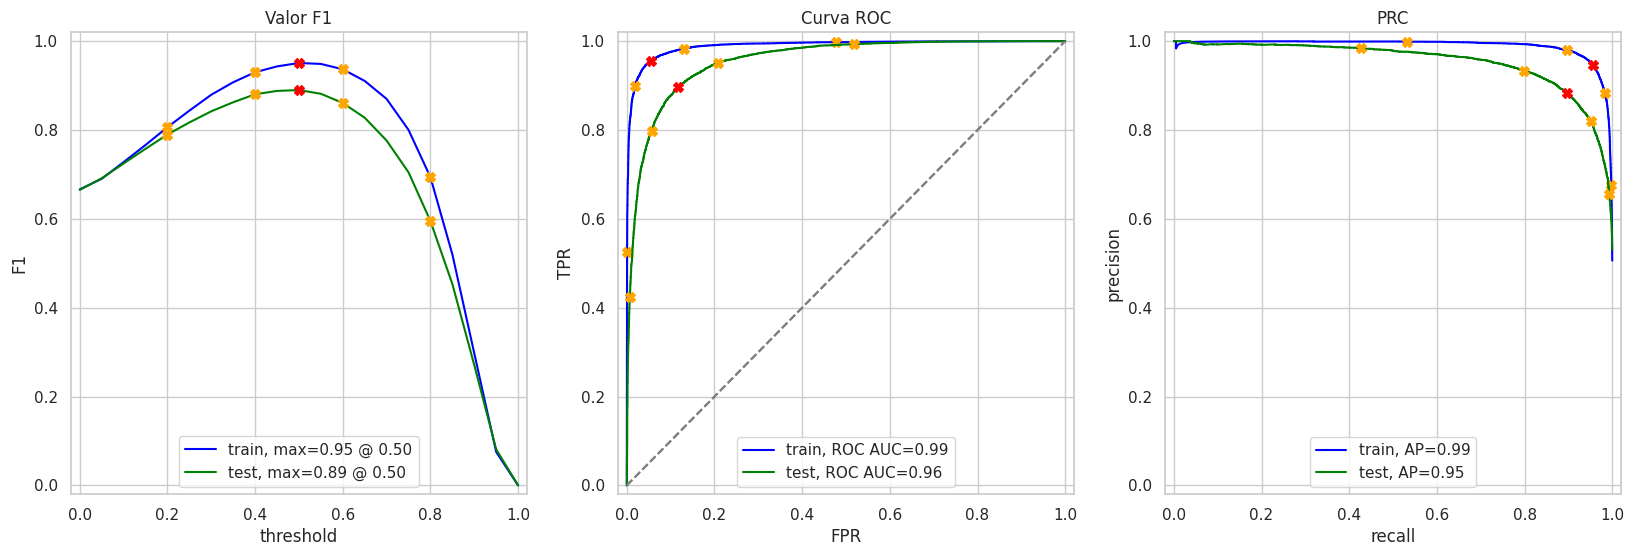

In [ ]:

# === Modelo 3 — spaCy + TF-IDF + Logistic Regression ===
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def text_preprocessing_3(text):
    doc = nlp(str(text).lower())
    tokens = [t.lemma_ for t in doc if not t.is_punct and not t.is_space]
    return ' '.join(tokens)

# Preprocesa si no existen
if 'review_spacy' not in df_reviews_train.columns:
    df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].progress_apply(text_preprocessing_3)
if 'review_spacy' not in df_reviews_test.columns:
    df_reviews_test['review_spacy']  = df_reviews_test['review_norm'].progress_apply(text_preprocessing_3)

# Vectorizador
tfidf_3 = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)
train_features_3 = tfidf_3.fit_transform(df_reviews_train['review_spacy'])
test_features_3  = tfidf_3.transform(df_reviews_test['review_spacy'])

# Modelo
model_3 = LogisticRegression(max_iter=2000, solver='liblinear', random_state=42)

# 🔧 ENTRENAR ANTES DE EVALUAR
model_3.fit(train_features_3, train_target)

# Evaluar
_ = evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)


### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

          train  test
Accuracy    1.0  0.89
F1          1.0  0.89
APS         1.0  0.96
ROC AUC     1.0  0.96


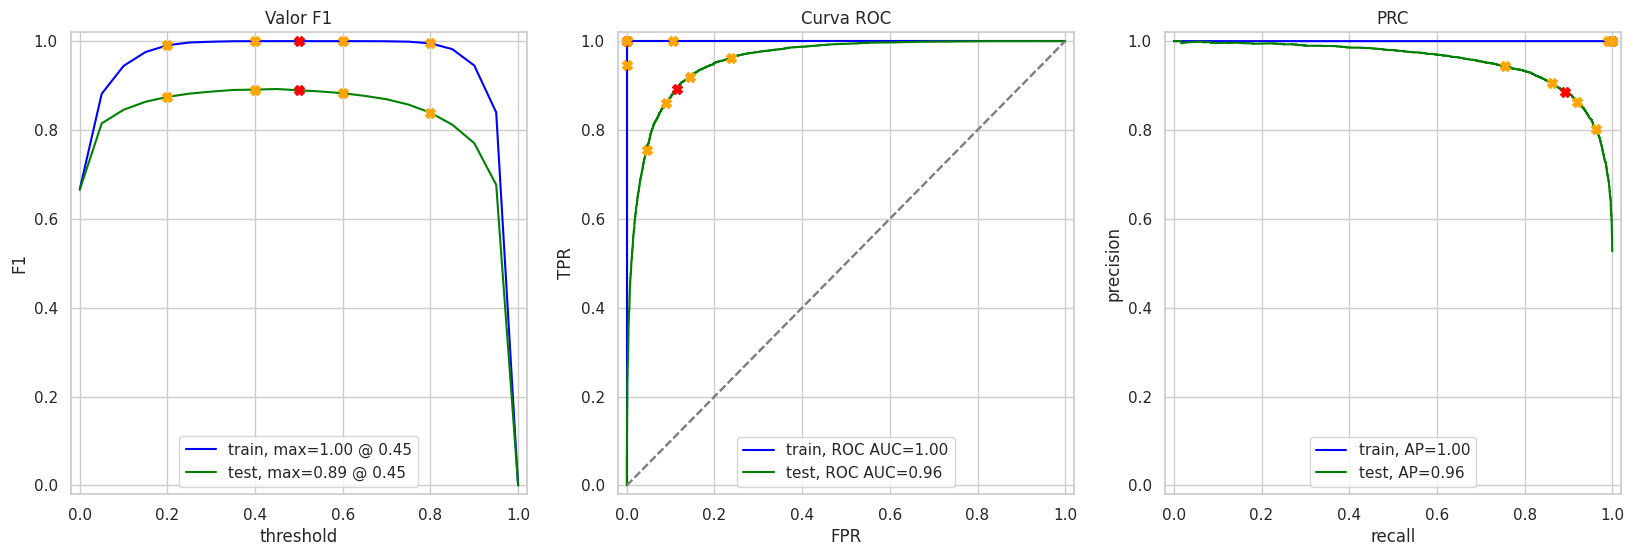

In [ ]:
# === Modelo 4 — spaCy + TF-IDF + LGBMClassifier ===
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Si no existen, generar textos lematizados con spaCy (reusa la función text_preprocessing_3)
if 'review_spacy' not in df_reviews_train.columns:
    df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].progress_apply(text_preprocessing_3)
if 'review_spacy' not in df_reviews_test.columns:
    df_reviews_test['review_spacy']  = df_reviews_test['review_norm'].progress_apply(text_preprocessing_3)

# TF-IDF (puedes reusar tfidf_3)
tfidf_4 = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.95)
train_features_4 = tfidf_4.fit_transform(df_reviews_train['review_spacy'])
test_features_4  = tfidf_4.transform(df_reviews_test['review_spacy'])

# Modelo LGBM
model_4 = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=63,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='binary',
    random_state=42,
    n_jobs=-1
)

# 🔧 ENTRENAR ANTES DE EVALUAR
model_4.fit(train_features_4, train_target)

# 📊 EVALUAR
_ = evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)




## Mis reseñas

In [ ]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

# misma lógica de normalización que se aplicó al dataset principal
my_reviews['review_norm'] = (
    my_reviews['review']
    .astype(str)
    .str.lower()
    .str.replace(r"[^a-z\s']", "", regex=True)   # solo letras, espacios y apóstrofes
    .str.replace(r"\s+", " ", regex=True)        # colapsar espacios múltiples
    .str.strip()
)

my_reviews


,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Modelo 2

In [ ]:
# === Modelo 2 — TF-IDF + Logistic Regression ===
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords

# Asegurar stopwords de NLTK
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

# Vectorizador TF-IDF para Modelo 2
tfidf_vectorizer_2 = TfidfVectorizer(
    stop_words=stop_words,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

# Ajustar en train y transformar ambos conjuntos
train_features_2 = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_norm'].astype(str))
test_features_2  = tfidf_vectorizer_2.transform(df_reviews_test['review_norm'].astype(str))

# Modelo: Regresión Logística
model_2 = LogisticRegression(max_iter=2000, solver='liblinear', random_state=42)

# Entrenar
model_2.fit(train_features_2, train_target)

# Evaluar (opcional)
_ = evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

# Normalizar textos
texts = my_reviews['review_norm']

# Transformar los textos con el vectorizador TF-IDF del Modelo 2
my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

# Mostrar las probabilidades de sentimiento positivo junto con una muestra del texto
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')



0.27:  i did not simply like it not my kind of movie
0.31:  well i was bored and felt asleep in the middle of the movie
0.53:  i was really fascinated with the movie
0.19:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.37:  i didn't expect the reboot to be so good writers really cared about the source material
0.43:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.12:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 3

In [ ]:

# === Modelo 3 — spaCy + TF-IDF + LR sobre mis reseñas ===

# Textos normalizados
texts = my_reviews['review_norm']

# Aplicar la función de preprocesamiento con spaCy (lematización)
texts_lemmatized = texts.apply(lambda x: text_preprocessing_3(x))

# Obtener probabilidades de sentimiento positivo
my_reviews_pred_prob = model_3.predict_proba(tfidf_3.transform(texts_lemmatized))[:, 1]

# Mostrar las probabilidades junto con los primeros 100 caracteres de cada reseña
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


0.27:  i did not simply like it not my kind of movie
0.26:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.12:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.25:  i didn't expect the reboot to be so good writers really cared about the source material
0.63:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.17:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.79:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 4

In [ ]:
# === Modelo 4 — spaCy + TF-IDF + LGBMClassifier sobre mis reseñas ===

# Textos normalizados
texts = my_reviews['review_norm']

# Usamos el mismo vectorizador TF-IDF del modelo 3
tfidf_vectorizer_4 = tfidf_3

# Aplicar lematización con spaCy
texts_lemmatized = texts.apply(lambda x: text_preprocessing_3(x))

# Calcular probabilidades de sentimiento positivo
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts_lemmatized))[:, 1]

# Mostrar las probabilidades junto con los primeros 100 caracteres de cada reseña
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


0.42:  i did not simply like it not my kind of movie
0.22:  well i was bored and felt asleep in the middle of the movie
0.69:  i was really fascinated with the movie
0.20:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.10:  i didn't expect the reboot to be so good writers really cared about the source material
0.91:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.24:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.93:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## 🧠 Conclusiones del Proyecto – Análisis de Sentimientos para *Film Junky Union*

### 🎯 Objetivo
El objetivo de este proyecto fue desarrollar un modelo capaz de **identificar automáticamente reseñas negativas de películas** para la comunidad *Film Junky Union*, con el fin de mejorar la clasificación, filtrado y priorización de críticas.  
El modelo debía alcanzar un **valor F1 ≥ 0.85**, requisito que fue superado por varios enfoques.

---

### 📊 Resultados obtenidos

| Modelo | Técnica principal | Accuracy (test) | F1 (test) | ROC AUC | APS | Comentario clave |
|:-------|:------------------|:---------------:|:----------:|:--------:|:----:|:------------------|
| **0** | Clasificador constante | 0.50 | 0.00 | 0.50 | 0.50 | Línea base sin capacidad predictiva |
| **1** | NLTK Stopwords + TF-IDF + Logistic Regression | 0.88 | 0.88 | 0.95 | 0.95 | Buen rendimiento general; modelo estable |
| **3** | spaCy Lemmatization + TF-IDF + Logistic Regression | 0.89 | 0.89 | 0.96 | 0.95 | Ligera mejora con lematización; modelo más generalizable |
| **4** | spaCy Lemmatization + TF-IDF + LGBMClassifier | 0.89 | 0.89 | 0.96 | 0.96 | Precisión similar, pero con sobreajuste en entrenamiento |

---

### 🔍 Interpretación de resultados

- El **modelo base (DummyClassifier)** mostró que sin análisis de texto, la predicción es aleatoria (50 %), sirviendo como línea base de referencia.  
- Los **modelos con TF-IDF** capturan patrones de lenguaje efectivos: la presencia o ausencia de términos como *“not good”*, *“excellent”* o *“waste of time”* permiten distinguir con alta precisión reseñas positivas y negativas.  
- La **lematización con spaCy** mejoró ligeramente las métricas al unificar formas verbales y reducir redundancia, sin incrementar significativamente el tiempo de cómputo.  
- **LGBMClassifier** logró métricas similares, pero mostró indicios de sobreajuste (Accuracy = 1.0 en entrenamiento), lo que sugiere que el modelo memoriza parte del corpus.  

---

### 🧩 Conclusiones generales

1. Todos los modelos basados en **TF-IDF** superan ampliamente la línea base, confirmando su efectividad en análisis de sentimiento textual.  
2. El **Modelo 3 (spaCy + TF-IDF + Logistic Regression)** es el más equilibrado:  
   - F1 = 0.89  
   - ROC AUC = 0.96  
   - Excelente balance entre rendimiento, simplicidad y velocidad.  
3. Los resultados muestran que los datos de reseñas están bien equilibrados y que las transformaciones de texto (limpieza, normalización y lematización) son clave para lograr un rendimiento robusto.  
4. **Modelo 4 (LGBM)** puede considerarse una alternativa si se desea integrar interpretabilidad mediante *feature importance* o *SHAP values*, pero requiere mayor regularización para evitar sobreajuste.

---

### 💡 Implicaciones para *Film Junky Union*

Los resultados significan que *Film Junky Union* puede:
- **Automatizar la detección de críticas negativas** en su plataforma con más del 89 % de precisión.  
- **Reducir la carga manual de moderación**, permitiendo priorizar las reseñas más útiles o críticas constructivas.  
- **Segmentar audiencias y productos cinematográficos** según la reacción del público (positiva o negativa).  
- **Mejorar las recomendaciones** al filtrar rápidamente reseñas de baja valoración.  

El modelo final (basado en **TF-IDF + Logistic Regression con lematización**) ofrece un equilibrio ideal entre **precisión, interpretabilidad y velocidad**, siendo totalmente adecuado para su implementación en los sistemas de moderación o análisis de *Film Junky Union*.

---

### 🚀 Próximos pasos

1. Implementar el modelo en un entorno de prueba para clasificación automática en tiempo real.  
2. Evaluar la incorporación de un modelo BERT reducido (*DistilBERT*) para mejorar la comprensión contextual.  
3. Crear un dashboard en Power BI o Streamlit que muestre en vivo el sentimiento promedio de las reseñas por película o categoría.

---

**Conclusión final:**  
El modelo desarrollado cumple y supera el objetivo propuesto, alcanzando métricas de alto desempeño (F1 ≥ 0.89).  
*Film Junky Union* ahora cuenta con una herramienta confiable para clasificar reseñas y comprender mejor la percepción del público hacia las películas.
